# LQ PROGRAMMING WORKBOOK

## Setting up the Law of Motion

#### Law of motion:

\begin{equation}
x_{t+1} = Ax_{t} + Bu_{t} + Cw_{t+1}
\end{equation}

set $\mathbf{y_{t} := \boldsymbol{\sigma} w_{t+1} + \boldsymbol{\mu}}$ and $\mathbf{u_{t} := c_{t}-\bar{c}}$

\begin{equation}
x_{t+1}:=\bigg(\begin{matrix}
a_{t+1}\\
1
\end{matrix}\bigg) =
\bigg(\begin{matrix}
1+r & -\bar{c}+\mu\\
0 & 1 
\end{matrix}\bigg)
\bigg(\begin{matrix}
a_{t}\\
1
\end{matrix}\bigg) +
\bigg(\begin{matrix}
-1\\
0
\end{matrix}\bigg)u_{t} +
\bigg(\begin{matrix}
\sigma\\
0
\end{matrix}\bigg)w_{t+1}
\end{equation}

### EXERCISE 1: write code to generate matrices A, B and C for the Law of Motion in the cell below


In [4]:
#CODE IT HERE:
# == Import Extra Packages ==#
# INSERT CODE HERE!
import numpy as np

# == Model parameters == #
r       = 0.05
c_bar   = 2
mu      = 1 
sigma   = 0.25


# == Formulate as an LQ problem == #
# INSERT CODE HERE!
A = np.array(([1 + r, -c_bar + mu],
     [0,     1]))
B = np.array(([-1],
     [0]))
C = np.array(([sigma],
     [0]))

# === Print out matrices, and their dimensions (or shape) == #
# INSERT CODE HERE!
print "A = ", A
print "Dimensions of A ", A.shape
print "B = ", B
print "Dimensions of B ", B.shape
print "C = ", C
print "Dimensions of C ", C.shape


A =  [[ 1.05 -1.  ]
 [ 0.    1.  ]]
Dimensions of A  (2, 2)
B =  [[-1]
 [ 0]]
Dimensions of B  (2, 1)
C =  [[ 0.25]
 [ 0.  ]]
Dimensions of C  (2, 1)


## Setting up the preferences

####Preferences:

\begin{equation}
x_{t}'R x_{t} + u_{t}'Q u_{t}
\end{equation}
                                                                                                                                                                                                                                                                                    
                                                                                                                                                                                                                
                                                                                                                                                                                                                                                                                    

We want to penalise squared deviations from 'bliss level' consumption, i.e. $\mathbf{c_{t} - \bar{c}}$, but don't care what value the state variable takes. Remember that our control is $\mathbf{u_{t} := c_{t}-\bar{c}}$.

### EXERCISE 2: write code to generate $Q$ and $R$ matrices in the cell below:

In [5]:
# == Formulate as an LQ problem == #
# INSERT CODE HERE!
Q = 1
R = np.zeros((2, 2))

# === Print out matrices, and their dimensions (or shape) == #
# INSERT CODE HERE!
print "Q = ", Q
print "Q is a scalar"
print "R = ", R
print "Dimensions of R ", R.shape

Q =  1
Q is a scalar
R =  [[ 0.  0.]
 [ 0.  0.]]
Dimensions of R  (2, 2)


##Optimality: Finite Horizon

#### FINITE HORIZON Objective function: 

\begin{equation}
E \bigg\{\sum_{t=0}^{T-1} \beta^{t}(x_{t}'R x_{t} + u_{t}'Q u_{t}) + \beta^{T}x_{T}'R_{f}x_{T} \bigg\} \quad \quad \quad (1)
\end{equation}
                                                                                                                                                                                                                                                                                    
                                                                                                                                                                                                                
                                                                                                                                                                                                                                                                                    

#### In our setup, we want to minimise:

\begin{equation}
E\bigg\{\sum_{t=0}^{T-1}\beta^{t}(c_{t}-\bar{c})^{2} + \beta^{T}qa_{T}^{2}\bigg\} \quad \quad \quad (2)
\end{equation}

\begin{align}
& \text{s.t.} \\
& x_{t+1}= Ax_{t} + Bu_{t} + Cw_{t}, \quad t\geq0 \\
& x_{0} \quad \text{given}
\end{align}



Here $q$ is a large positive constant, the role of which is to induce the consumer to target zero debt at the end of her life.

We already have a lot of this problem set up, since we already coded up the law of motion, and have the $R$ and $Q$ matrices. Map equation (2) into the FINITE HORIZON objective function (1) by adding $R_{f}$:

\begin{equation}
R_{f}=\bigg(\begin{matrix}
        q&0\\
        0&0\end{matrix}\bigg)
\end{equation}

## EXERCISE 3: write code to generate the $R_f$ matrix in the cell below:

In [6]:
# == Model parameters == #
T       = 45
beta    = 1 / (1 + r)
q       = 1e6


# == Formulate as an LQ problem == #
# INSERT CODE HERE!
Rf = np.zeros((2, 2))
Rf[0, 0] = q


# === Print out matrix, and its dimensions (or shape) == #
# INSERT CODE HERE!
print "R = ", Rf
print "Dimensions of Rf", Rf.shape


R =  [[ 1000000.        0.]
 [       0.        0.]]
Dimensions of Rf (2, 2)


# THE CODE TO SOLVE LQ PROBLEMS!

In [7]:
"""
Filename: lqcontrol.py

Authors: Thomas J. Sargent, John Stachurski

Provides a class called LQ for solving linear quadratic control
problems.

"""
from textwrap import dedent
import numpy as np
from numpy import dot
from scipy.linalg import solve
from quantecon.matrix_eqn import solve_discrete_riccati


class LQ(object):
    r"""
    This class is for analyzing linear quadratic optimal control
    problems of either the infinite horizon form

    .     min E sum_{t=0}^{\infty} beta^t r(x_t, u_t)

    with

         r(x_t, u_t) := x_t' R x_t + u_t' Q u_t + 2 u_t' N x_t

    or the finite horizon form

         min E sum_{t=0}^{T-1} beta^t r(x_t, u_t) + beta^T x_T' R_f x_T

    Both are minimized subject to the law of motion

         x_{t+1} = A x_t + B u_t + C w_{t+1}

    Here x is n x 1, u is k x 1, w is j x 1 and the matrices are
    conformable for these dimensions.  The sequence {w_t} is assumed to
    be white noise, with zero mean and E w_t w_t = I, the j x j
    identity.

    If C is not supplied as a parameter, the model is assumed to be
    deterministic (and C is set to a zero matrix of appropriate
    dimension).

    For this model, the time t value (i.e., cost-to-go) function V_t
    takes the form

         x' P_T x + d_T

    and the optimal policy is of the form u_T = -F_T x_T.  In
    the infinite horizon case, V, P, d and F are all stationary.

    Parameters
    ----------
    Q : array_like(float)
        Q is the payoff(or cost) matrix that corresponds with the
        control variable u and is k x k. Should be symmetric and
        nonnegative definite
    R : array_like(float)
        R is the payoff(or cost) matrix that corresponds with the
        state variable x and is n x n. Should be symetric and
        non-negative definite
    N : array_like(float)
        N is the cross product term in the payoff, as above.  It should
        be k x n.
    A : array_like(float)
        A is part of the state transition as described above. It should
        be n x n
    B : array_like(float)
        B is part of the state transition as described above. It should
        be n x k
    C : array_like(float), optional(default=None)
        C is part of the state transition as described above and
        corresponds to the random variable today.  If the model is
        deterministic then C should take default value of None
    beta : scalar(float), optional(default=1)
        beta is the discount parameter
    T : scalar(int), optional(default=None)
        T is the number of periods in a finite horizon problem.
    Rf : array_like(float), optional(default=None)
        Rf is the final (in a finite horizon model) payoff(or cost)
        matrix that corresponds with the control variable u and is n x
        n.  Should be symetric and non-negative definite


    Attributes
    ----------
    Q, R, N, A, B, C, beta, T, Rf : see Parameters
    P : array_like(float)
        P is part of the value function representation of V(x) = x'Px + d
    d : array_like(float)
        d is part of the value function representation of V(x) = x'Px + d
    F : array_like(float)
        F is the policy rule that determines the choice of control in
        each period.
    k, n, j : scalar(int)
        The dimensions of the matrices as presented above

    """

    def __init__(self, Q, R, A, B, C=None, N=None, beta=1, T=None, Rf=None):
        # == Make sure all matrices can be treated as 2D arrays == #
        converter = lambda X: np.atleast_2d(np.asarray(X, dtype='float32'))
        self.A, self.B, self.Q, self.R, self.N = list(map(converter,
                                                          (A, B, Q, R, N)))
        # == Record dimensions == #
        self.k, self.n = self.Q.shape[0], self.R.shape[0]

        self.beta = beta

        if C is None:
            # == If C not given, then model is deterministic. Set C=0. == #
            self.j = 1
            self.C = np.zeros((self.n, self.j))
        else:
            self.C = converter(C)
            self.j = self.C.shape[1]

        if N is None:
            # == No cross product term in payoff. Set N=0. == #
            self.N = np.zeros((self.k, self.n))

        if T:
            # == Model is finite horizon == #
            self.T = T
            self.Rf = np.asarray(Rf, dtype='float32')
            self.P = self.Rf
            self.d = 0
        else:
            self.P = None
            self.d = None
            self.T = None

        self.F = None

    def __repr__(self):
        return self.__str__()

    def __str__(self):
        m = """\
        Linear Quadratic control system
          - beta (discount parameter)   : {b}
          - T (time horizon)            : {t}
          - n (number of state variables)   : {n}
          - k (number of control variables) : {k}
          - j (number of shocks)            : {j}
        """
        t = "infinite" if self.T is None else self.T
        return dedent(m.format(b=self.beta, n=self.n, k=self.k, j=self.j,
                               t=t))

    def update_values(self):
        """
        This method is for updating in the finite horizon case.  It
        shifts the current value function

             V_t(x) = x' P_t x + d_t

        and the optimal policy F_t one step *back* in time,
        replacing the pair P_t and d_t with
        P_{t-1} and d_{t-1}, and F_t with
        F_{t-1}

        """
        # === Simplify notation === #
        Q, R, A, B, N, C = self.Q, self.R, self.A, self.B, self.N, self.C
        P, d = self.P, self.d
        # == Some useful matrices == #
        S1 = Q + self.beta * dot(B.T, dot(P, B))
        S2 = self.beta * dot(B.T, dot(P, A)) + N
        S3 = self.beta * dot(A.T, dot(P, A))
        # == Compute F as (Q + B'PB)^{-1} (beta B'PA + N) == #
        self.F = solve(S1, S2)
        # === Shift P back in time one step == #
        new_P = R - dot(S2.T, self.F) + S3
        # == Recalling that trace(AB) = trace(BA) == #
        new_d = self.beta * (d + np.trace(dot(P, dot(C, C.T))))
        # == Set new state == #
        self.P, self.d = new_P, new_d

    def stationary_values(self):
        """
        Computes the matrix P and scalar d that represent the value
        function

             V(x) = x' P x + d

        in the infinite horizon case.  Also computes the control matrix
        F from u = - Fx

        Returns
        -------
        P : array_like(float)
            P is part of the value function representation of
            V(x) = xPx + d
        F : array_like(float)
            F is the policy rule that determines the choice of control
            in each period.
        d : array_like(float)
            d is part of the value function representation of
            V(x) = xPx + d

        """
        # === simplify notation === #
        Q, R, A, B, N, C = self.Q, self.R, self.A, self.B, self.N, self.C

        # === solve Riccati equation, obtain P === #
        A0, B0 = np.sqrt(self.beta) * A, np.sqrt(self.beta) * B
        P = solve_discrete_riccati(A0, B0, R, Q, N)

        # == Compute F == #
        S1 = Q + self.beta * dot(B.T, dot(P, B))
        S2 = self.beta * dot(B.T, dot(P, A)) + N
        F = solve(S1, S2)

        # == Compute d == #
        d = self.beta * np.trace(dot(P, dot(C, C.T))) / (1 - self.beta)

        # == Bind states and return values == #
        self.P, self.F, self.d = P, F, d

        return P, F, d

    def compute_sequence(self, x0, ts_length=None):
        """
        Compute and return the optimal state and control sequences
        x_0, ..., x_T and u_0,..., u_T  under the
        assumption that {w_t} is iid and N(0, 1).

        Parameters
        ===========
        x0 : array_like(float)
            The initial state, a vector of length n

        ts_length : scalar(int)
            Length of the simulation -- defaults to T in finite case

        Returns
        ========
        x_path : array_like(float)
            An n x T matrix, where the t-th column represents x_t

        u_path : array_like(float)
            A k x T matrix, where the t-th column represents u_t

        w_path : array_like(float)
            A j x T matrix, where the t-th column represent w_t

        """

        # === Simplify notation === #
        A, B, C = self.A, self.B, self.C

        # == Preliminaries, finite horizon case == #
        if self.T:
            T = self.T if not ts_length else min(ts_length, self.T)
            self.P, self.d = self.Rf, 0

        # == Preliminaries, infinite horizon case == #
        else:
            T = ts_length if ts_length else 100
            self.stationary_values()

        # == Set up initial condition and arrays to store paths == #
        x0 = np.asarray(x0)
        x0 = x0.reshape(self.n, 1)  # Make sure x0 is a column vector
        x_path = np.empty((self.n, T+1))
        u_path = np.empty((self.k, T))
        w_path = dot(C, np.random.randn(self.j, T+1))

        # == Compute and record the sequence of policies == #
        policies = []
        for t in range(T):
            if self.T:  # Finite horizon case
                self.update_values()
            policies.append(self.F)

        # == Use policy sequence to generate states and controls == #
        F = policies.pop()
        x_path[:, 0] = x0.flatten()
        u_path[:, 0] = - dot(F, x0).flatten()
        for t in range(1, T):
            F = policies.pop()
            Ax, Bu = dot(A, x_path[:, t-1]), dot(B, u_path[:, t-1])
            x_path[:, t] = Ax + Bu + w_path[:, t]
            u_path[:, t] = - dot(F, x_path[:, t])
        Ax, Bu = dot(A, x_path[:, T-1]), dot(B, u_path[:, T-1])
        x_path[:, T] = Ax + Bu + w_path[:, T]

        return x_path, u_path, w_path

## Notes on the code

In the module, the various updating, simulation and fixed point methods are wrapped in a class called LQ, which includes

Instance data:

* The required parameters $Q,R,A,B$ and optional parameters $C,\beta,T,R_{f}, N$ specifying a given LQ model
    * set $T$ and $R_{f}$ to None in the infinite horizon case
    * set $C =$ None (or zero) in the deterministic case
    
    
* The value function and policy data
    * $d_{t},P_{t},F_{t}$ in the finite horizon case
    * $d,P,F$ in the infinite horizon case


Methods:
* update_values — shifts $d_{t},P_{t},F_{t}$ to their $t−1$ values
* stationary_values — computes $P,d,F$ in the infinite horizon case
* compute_sequence —- simulates the dynamics of $x_{t},u_{t},w_{t}$ given $x_{0}$ and assuming standard normal shocks

## So let's see what our model does!

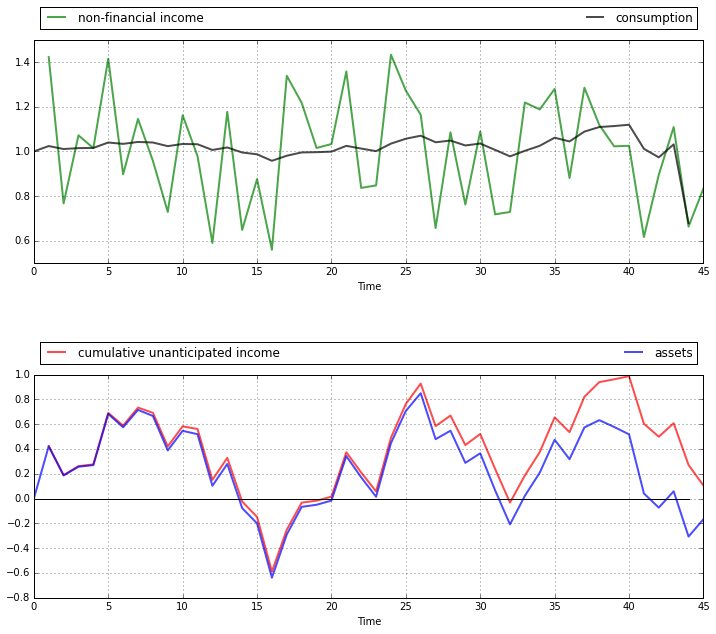

In [8]:
# == Import Extra Packages ==#
import matplotlib.pyplot as plt
%matplotlib inline
from quantecon import LQ


# == Compute solutions and simulate == #
# Call the LQ class and feed it all of our matrices
lq = LQ(Q, R, A, B, C, beta=beta, T=T, Rf=Rf)
# We need an initial condition
x0 = (0, 1)
# One of the methods of our class is able to create a simulation
xp, up, wp = lq.compute_sequence(x0)

# == Convert back to assets, consumption and income == #
assets = xp[0, :]           # a_t
c = up.flatten() + c_bar    # c_t
income = wp[0, 1:] + mu     # y_t

# == Plot results == #
n_rows = 2
fig, axes = plt.subplots(n_rows, 1, figsize=(12, 10))

plt.subplots_adjust(hspace=0.5)
for i in range(n_rows):
    axes[i].grid()
    axes[i].set_xlabel(r'Time')
bbox = (0., 1.02, 1., .102)
legend_args = {'bbox_to_anchor': bbox, 'loc': 3, 'mode': 'expand'}
p_args = {'lw': 2, 'alpha': 0.7}

axes[0].plot(list(range(1, T+1)), income, 'g-', label="non-financial income",
             **p_args)
axes[0].plot(list(range(T)), c, 'k-', label="consumption", **p_args)
axes[0].legend(ncol=2, **legend_args)

axes[1].plot(list(range(1, T+1)), np.cumsum(income - mu), 'r-',
             label="cumulative unanticipated income", **p_args)
axes[1].plot(list(range(T+1)), assets, 'b-', label="assets", **p_args)
axes[1].plot(list(range(T)), np.zeros(T), 'k-')
axes[1].legend(ncol=2, **legend_args)

plt.show()

The time path of consumption is much smoother than that for income.

(But note that consumption becomes more irregular towards the end of life, when the zero final asset requirement impinges more on consumption choices)

The second panel in the figure shows that the time path of assets at is closely correlated with cumulative unanticipated income, which is defined as $z_{t}:=\sum_{j=0}^{t}\sigma w_{t} = \sum_{j=0}^{t}(y_{t} - \mu)$





### EXERCISE 4: calculate the correlation between cumulative unanticipated income and the path for assets

In [10]:
# INSERT CODE HERE! Hint: use numpy package cumsum and corrcoef
# you will also need to figure out how to make the two vectors the same length! (assets is shorter)
correlation = np.corrcoef(np.cumsum(income - mu),assets[1:])
print correlation

[[ 1.          0.87578048]
 [ 0.87578048  1.        ]]


A key message is that unanticipated windfall gains are saved rather than consumed, while unanticipated negative shocks are met by reducing assets

(Again, this relationship breaks down towards the end of life due to the zero final asset requirement)

### EXERCISE 5: increase $\beta$ from $1/(1+r)≈0.952$ to $0.96$ while keeping other parameters fixed

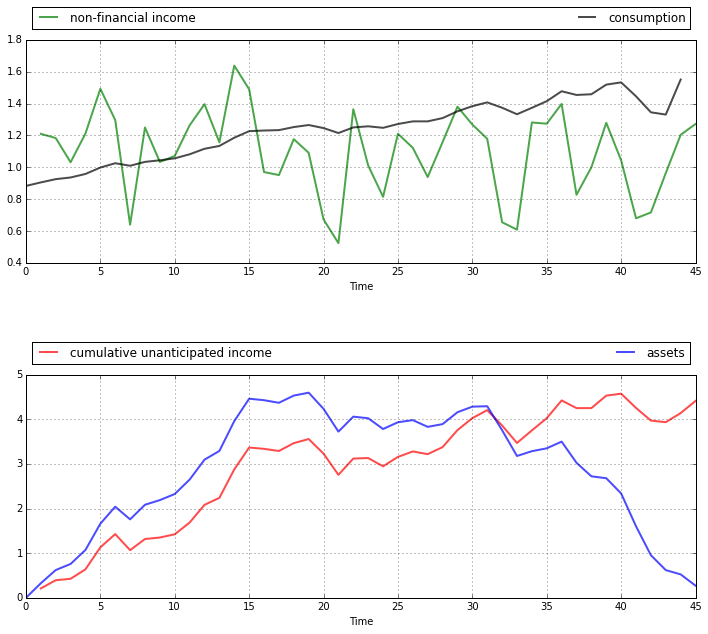

In [11]:
# == Change our parameters == #
# INSERT CODE HERE
beta = 0.96
r = (1-beta)/beta

# == Compute solutions and simulate == #
# Call the LQ class and feed it all of our matrices
lq = LQ(Q, R, A, B, C, beta=beta, T=T, Rf=Rf)
# We need an initial condition
x0 = (0, 1)
# One of the methods of our class is able to create a simulation
xp, up, wp = lq.compute_sequence(x0)

# == Convert back to assets, consumption and income == #
assets = xp[0, :]           # a_t
c = up.flatten() + c_bar    # c_t
income = wp[0, 1:] + mu     # y_t

# == Plot results == #
n_rows = 2
fig, axes = plt.subplots(n_rows, 1, figsize=(12, 10))

plt.subplots_adjust(hspace=0.5)
for i in range(n_rows):
    axes[i].grid()
    axes[i].set_xlabel(r'Time')
bbox = (0., 1.02, 1., .102)
legend_args = {'bbox_to_anchor': bbox, 'loc': 3, 'mode': 'expand'}
p_args = {'lw': 2, 'alpha': 0.7}

axes[0].plot(list(range(1, T+1)), income, 'g-', label="non-financial income",
             **p_args)
axes[0].plot(list(range(T)), c, 'k-', label="consumption", **p_args)
axes[0].legend(ncol=2, **legend_args)

axes[1].plot(list(range(1, T+1)), np.cumsum(income - mu), 'r-',
             label="cumulative unanticipated income", **p_args)
axes[1].plot(list(range(T+1)), assets, 'b-', label="assets", **p_args)
axes[1].plot(list(range(T)), np.zeros(T), 'k-')
axes[1].legend(ncol=2, **legend_args)

plt.show()

## EXERCISE 6 What is different from last time?


####Hint: compare the plots, and re calculate the correlation between unexpected income and assets 


A: This consumer is slightly more patient than the last one, and hence puts relatively more weight on later consumption values. The correlation between cumulative unanticipated income and assets is also smaller:

In [12]:
correlation = np.corrcoef(np.cumsum(income - mu),assets[1:])
print correlation

[[ 1.          0.39630414]
 [ 0.39630414  1.        ]]


# Application: Nonstationary Income

One unrealistic feature of that model is the assumption that the mean of the random income process does not depend on the consumer’s age

A more realistic income profile is one that rises in early working life, peaks towards the middle and maybe declines toward end of working life, and falls more during retirement

In this section, we will model this rise and fall as a symmetric inverted “U” using a polynomial in age

   For income we now take $\mathbf{y_{t}=p(t)+\boldsymbol{\sigma} w_{t+1}}$ where $\mathbf{p(t):=m_{0}+m_{1}t+m_{2}t^{2}}$

The coefficients $\mathbf{m_{0},m_{1},m_{2}}$ are chosen such that $\mathbf{p(0)=0,p(T/2)=\mu}$, and $\mathbf{p(T)=0}$

You can confirm that the specification $\quad \mathbf{m_{0}=0, \quad m_{1}=T\mu /(T/2)^{2}, \quad m_{2}=−\mu /(T/2)^{2}} \quad$ satisfies these constraints

To put this into an LQ setting, consider the budget constraint, which becomes:

\begin{equation}
a_{t+1}=(1+r)a_{t}−u_{t}−\bar{c}+m_{1}t+m_{2}t^{2}+\sigma w_{t+1}
\end{equation}

The fact that $a_{t+1}$ is a linear function of $(a_{t},1,t,t^{2})$ suggests taking these four variables as the state vector $x_{t}$

Once a good choice of state and control (recall $u_{t}=c_{t}−\bar{c}$) has been made, the remaining specifications fall into place relatively easily

Thus, for the dynamics we set

\begin{equation}
x_{t+1}:=
\begin{vmatrix}
a_{t+1}\\
1\\
t \\
t^{2}
\end{vmatrix} \quad A :=
\begin{vmatrix}
1+r & -\bar{c} & m1 & m2 \\
0 & 1 & 0 & 0 \\
0 & 1 & 1 & 0 \\
0 & 1 & 2 & 1
\end{vmatrix} \quad B:=
\begin{vmatrix}
-1\\
0 \\
0\\
0
\end{vmatrix} \quad C:=
\begin{vmatrix}
\sigma\\
0 \\
0\\
0
\end{vmatrix}
\end{equation}

To implement the preference specification we take:



\begin{equation}
Q:= 1 \quad
R:=
\begin{vmatrix}
0 & 0 & 0 & 0\\
0 & 0 & 0 & 0\\
0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0
\end{vmatrix} \quad R_{f} :=
\begin{vmatrix}
q & 0 & 0 & 0\\
0 & 0 & 0 & 0\\
0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0
\end{vmatrix}
\end{equation}

## EXERCISE 7: Implement this life-cycle specification by changing the code below. 

####You will need to code the matrices as before and copy/paste from the code above, changing relevant parts to solve the model and plot the simulated data

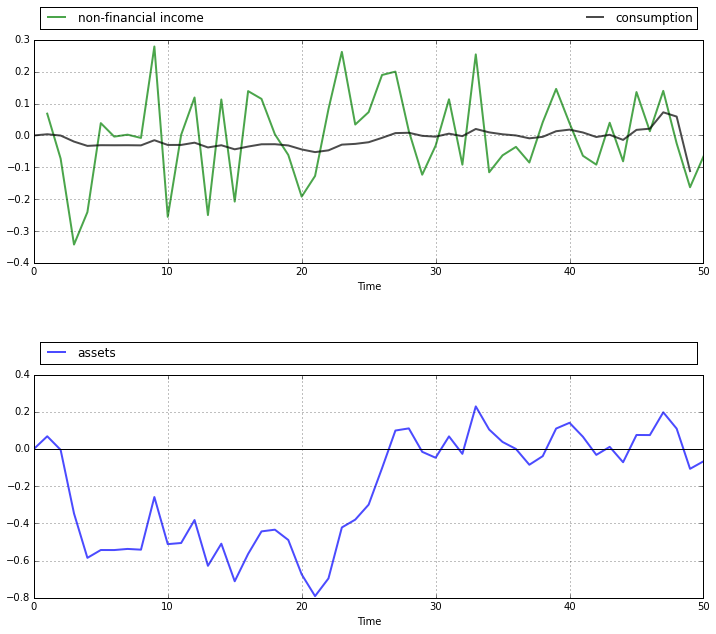

In [13]:
# == Model parameters == #
r       = 0.05
beta    = 1 / (1 + r)
T       = 50
c_bar   = 1.5
sigma   = 0.15
mu      = 2
q       = 1e4
m1      = T * (mu / (T/2)**2)
m2      = - (mu / (T/2)**2)

# == Formulate as an LQ problem == #
# INSERT CODE HERE!##########################################################################################

Q = 1
R = np.zeros((4, 4)) 
Rf = np.zeros((4, 4))
Rf[0, 0] = q
A = [[1 + r, -c_bar, m1, m2], 
     [0,     1,      0,  0],
     [0,     1,      1,  0],
     [0,     1,      2,  1]]
B = [[-1],
     [0],
     [0],
     [0]]
C = [[sigma],
     [0],
     [0],
     [0]]

###############################################################################################################


# == Compute solutions and simulate == #
# INSERT CODE HERE!##########################################################################################
lq = LQ(Q, R, A, B, C, beta=beta, T=T, Rf=Rf)
x0 = (0, 1, 0, 0)
xp, up, wp = lq.compute_sequence(x0)


##############################################################################################################

# == Convert results back to assets, consumption and income == #
ap = xp[0, :]               # Assets
c = up.flatten() + c_bar    # Consumption
time = np.arange(1, T+1)
income = wp[0, 1:] + m1 * time + m2 * time**2  # Income


# == Plot results == #
# INSERT CODE HERE!##########################################################################################
n_rows = 2
fig, axes = plt.subplots(n_rows, 1, figsize=(12, 10))

plt.subplots_adjust(hspace=0.5)
for i in range(n_rows):
    axes[i].grid()
    axes[i].set_xlabel(r'Time')
bbox = (0., 1.02, 1., .102)
legend_args = {'bbox_to_anchor' : bbox, 'loc' : 3, 'mode' : 'expand'}
p_args = {'lw' : 2, 'alpha' : 0.7}

axes[0].plot(range(1, T+1), income, 'g-', label="non-financial income", **p_args)
axes[0].plot(range(T), c, 'k-', label="consumption", **p_args)
axes[0].legend(ncol=2, **legend_args)

axes[1].plot(range(T+1), ap.flatten(), 'b-', label="assets", **p_args)
axes[1].plot(range(T+1), np.zeros(T+1), 'k-')
axes[1].legend(ncol=1, **legend_args)

plt.show()
###############################################################################################################

## EXERCISE 8: does it exhibit consumption smoothing? Is it consistent with life-cyle theory?


A: Once again, smooth consumption is a dominant feature of the sample paths

The asset path exhibits dynamics consistent with standard life cycle theory

#Application: Hall's Permanent Income Model in Infinite Time

\begin{align}
a_{t+1} +  c_{t} & = (1+r)ra_{t} + y_{t} \\
y_{t} & = \mu_{y}(1-\rho)  + \rho y_{t-1} + \sigma(w_{t+1})
\end{align}

Map this into a linear regulator problem by taking 
 $u_{t} = c_{t}-\bar{c}$ as the control 
  $x_{t} = [1 \; a_{t+1}  y_{t}]'$ as the state. Solve the model and simulate, then plot 2 graphs: on one, consumption and non-financial income; on the other, assets.

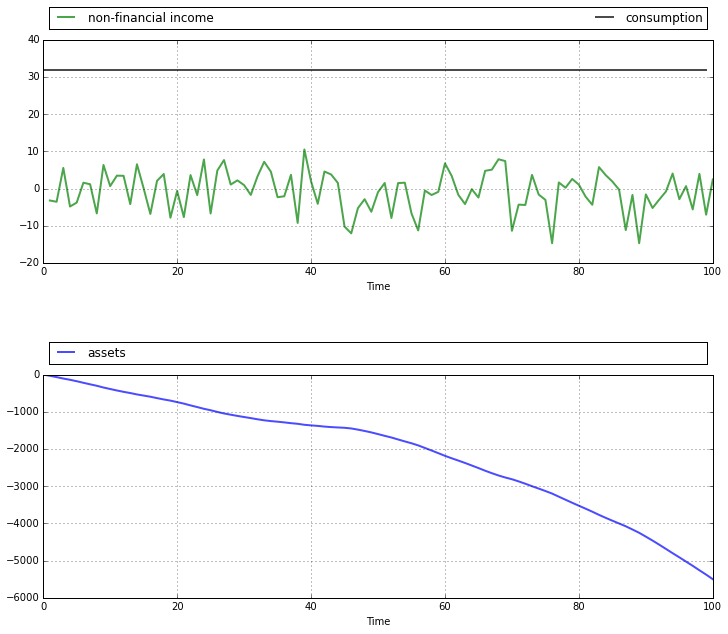

In [21]:
# == Model parameters == #
# c_bar is 'bliss level' consumption
c_bar = 32.0
# (1+r) is time invariant gross rate of return on financial assets a_{t-1}
# (1+r) = 1/beta following Hansen, Sargent and Tallarini (1999)
beta = 0.9971
r = (1.0/beta)-1
#rho is persistence of endowment process
rho = 0.9992
#mu_d constant term in endowment process - https://files.nyu.edu/ts43/public/research/AP_tom16.pdf
mu_d = 13.710
#c_d is constant on stochastic part of endowment process
sigma = 5.5819


# == Formulate as an LQ problem == #
# INSERT CODE HERE!##########################################################################################
A = np.array([[1.0,0.0,0.0],[-c_bar,1+r,1.0],[(1.0-rho)*mu_d,0.0,rho]])
B = np.array([[0.0],[-1.0],[0.0]])
C = np.array([[0.0],[0.0],[sigma]])


R = np.zeros((3,3))
Q = 1.0


##############################################################################################################
# == Compute solutions and simulate == #
#T is now the length of the simulation, rather than being passed to the LQ class
T=100
# INSERT CODE HERE!##########################################################################################
lq = LQ(Q, R, A, B, C, beta=beta, Rf=Rf)
x0 = (1, 0, 0)
xp, up, wp = lq.compute_sequence(x0)

# == Convert back to assets, consumption and income == #
assets = xp[1, :]           # a_t
c = up.flatten()  + c_bar   # c_t
income = wp[2, 1:]          # y_t

# == Plot results == #
n_rows = 2
fig, axes = plt.subplots(n_rows, 1, figsize=(12, 10))

plt.subplots_adjust(hspace=0.5)
for i in range(n_rows):
    axes[i].grid()
    axes[i].set_xlabel(r'Time')
bbox = (0., 1.02, 1., .102)
legend_args = {'bbox_to_anchor': bbox, 'loc': 3, 'mode': 'expand'}
p_args = {'lw': 2, 'alpha': 0.7}

axes[0].plot(list(range(1, T+1)), income, 'g-', label="non-financial income",
             **p_args)
axes[0].plot(list(range(T)), c, 'k-', label="consumption", **p_args)
axes[0].legend(ncol=2, **legend_args)

axes[1].plot(list(range(T+1)), assets, 'b-', label="assets", **p_args)
axes[1].plot(list(range(T)), np.zeros(T), 'k-')
axes[1].legend(ncol=2, **legend_args)

plt.show()
##############################################################################################################

# Application: A Permanent Income Model with Retirement¶

Exercise 2, from here: http://quant-econ.net/py/lqcontrol.html#solution-lqc-ex2-fig

# Application: Monopoly with Adjustment Costs

Exercise 3, from here: http://quant-econ.net/py/lqcontrol.html#solution-lqc-ex2-fig